# Exercise 18 - Variations of Physics-Informed Neural Networks
### Tasks
1. Study the variations of PINNs

In block 15, choose from the following cost functions:
- Physics-informed neural network (PINN)
- Deep Galerkin method (DGM)
- Deep energy method (DEM) (to see the cost history, remove the logscale in block 20) 
- Variational physics-informed neural network (VPINN)

To enable the Weak adversarial network (WAN), use the VPINN cost function and uncomment the neural network (modelW) for the test functions in block 19.

2. Next, switch to problem b (see the exercise description) in block 16. The issue is the weak singularity at the left edge. By changing the integration technique in block 4 to midPointIntegration, the singularity is no longer evaluated. Compare the PINN and the DEM for case b. What happens if you reduce the number of collocation points Nx in block 17? Hint: also reduce the number of epochs for DEM to prevent overfitting.

Note that the boundary conditions are implemented differently and in a less general manner. The `getDisplacements` function checks for homogeneous Dirichlet boundary conditions on the left and right edge (block 8), while inhomogeneous Neumann boundary conditions are checked directly in the different cost functions (block 10-13).

### Learning goals
- Understand the differences between the main PINN variations and their robustness
- Be able to implement the main PINN variations
- Gain intuition on the capabilities of the PINN variations

**import libraries & set seed**

In [5]:
import numpy as np
import torch
from torch.autograd import grad
import time
import matplotlib.pyplot as plt

In [6]:
torch.manual_seed(2)

## Utilities

**gradient computation with automatic differentiation**

In [7]:
def getDerivative(y, x, n):
    """Compute the nth order derivative of y = f(x) with respect to x."""

    if n == 0:
        return y
    else:
        dy_dx = grad(
            y, x, torch.ones(x.size()[0], 1), create_graph=True, retain_graph=True
        )[0]
        return getDerivative(dy_dx, x, n - 1)

**numerical integration**

In [8]:
def midpointIntegration(y, x):
    dx = x[1] - x[0]  # Compute delta x assuming it's constant over the range of x

    return torch.sum(y, axis=0) * dx


def trapezoidalIntegration(y, x):
    dx = x[1] - x[0]  # Compute delta x assuming it's constant over the range of x

    # Compute the integral with the trapezoidal rule
    result = torch.sum(y, axis=0)
    result = result - (y[0] + y[-1]) / 2

    return result * dx

**select numerical integration**

In [9]:
# getIntegral = midpointIntegration
getIntegral = trapezoidalIntegration

**neural network**

In [10]:
class NN(torch.nn.Module):
    def __init__(
        self,
        inputDimension,
        hiddenDimensions,
        outputDimension,
        activationFunction=torch.nn.Tanh(),
    ):
        super().__init__()

        modules = []

        modules.append(torch.nn.Linear(inputDimension, hiddenDimensions[0]))
        modules.append(activationFunction)
        for i in range(len(hiddenDimensions) - 1):
            modules.append(
                torch.nn.Linear(hiddenDimensions[i], hiddenDimensions[i + 1])
            )
            modules.append(activationFunction)
        modules.append(torch.nn.Linear(hiddenDimensions[-1], outputDimension))

        self.model = torch.nn.Sequential(*modules)

    def forward(self, x):
        return self.model(x)

**initialization of neural network weights**

In [11]:
def initWeights(m):
    """Initialize weights of neural network with xavier initialization."""
    if type(m) == torch.nn.Linear:
        torch.nn.init.xavier_uniform_(
            m.weight, gain=torch.nn.init.calculate_gain("tanh")
        )  # adapt if using a different initialization
        m.bias.data.fill_(0.0)

## PINN helper functions

**displacement computation**
$$\hat{u}=F_{NN}(x)$$

In [12]:
def getDisplacements(model, x, uB, L):  # only works for homogeneous boundary conditions
    u = model(x)
    if np.any(np.all(np.array(uB) == [0, 0, 0], axis=1)):
        u *= x
    if np.any(np.all(np.array(uB) == [0, 0, L], axis=1)):
        u *= L - x

    return u

**test functions**

In [13]:
class testFunctions(torch.nn.Module):
    def __init__(self, x, n, L):
        super().__init__()
        self.paramters = None

        self.testFunctions = torch.zeros((len(x), n))
        for i in range(n):
            self.testFunctions[:, i] = 1.0 - torch.cos(
                (i + 1) * np.pi / L * x[:, 0]
            )  # assumes a Dirichlet boundary condition at the left edge

    def forward(self, x):
        return torch.clone(
            self.testFunctions
        )  # necessary as it is otherwise directly modified in getTestFunctions

**test function computation with consideration of Dirichlet boundary conditions**

In [14]:
def getTestFunctions(model, x, uB, L):
    w = model(x)
    if np.any(np.all(np.array(uB)[:, 1:] == [0, 0], axis=1)):
        w *= x
    if np.any(np.all(np.array(uB)[:, 1:] == [0, L], axis=1)):
        w *= L - x
    return w

**cost function computation**

## Physics-informed loss function
The differential equation loss
$$\mathcal{L}_\mathcal{R}=\sum_{i=1}^N\bigl(\frac{d}{dx}EA(x_i)\bigl(\frac{d\hat{u}(x_i)}{dx}\bigr)+p(x_i)\bigr)^2$$
The boundary condition loss 
$$\mathcal{L}_\mathcal{B}=\sum_{i=1}^{N_B}\bigl( \frac{d^{n_i} \hat{u}(x_i)}{dx^{n_i}} - F_i \bigr)^2$$
$$C = \mathcal{L}_\mathcal{R} + \mathcal{L}_\mathcal{B}$$

## Deep Galerkin method
The differential equation loss
$$\mathcal{L}_\mathcal{R}=\int_0^L \bigl(\frac{d}{dx}EA(x)\bigl(\frac{d\hat{u}(x)}{dx}\bigr)+p(x)\bigr)^2 v(x) dx$$
$$v(x)\sim U(0,1)$$
The boundary condition loss 
$$\mathcal{L}_\mathcal{B}=\sum_{i=1}^{N_B}\bigl( \frac{d^{n_i} \hat{u}(x_i)}{dx^{n_i}} - F_i \bigr)^2$$
$$C = \mathcal{L}_\mathcal{R} + \mathcal{L}_\mathcal{B}$$

## Variational physics-informed neural networks
$$C = \sum_{i=1}^{N_{\mathcal{W}}} \Bigl( -\int_0^L \frac{du(x)}{dx}EA(x)\frac{dw_i(x)}{dx} dx + \int_0^L p(x) w_i(x) dx + \int_{\Gamma_N} \frac{du(x)}{dx}EA(x) w_i(x)d\Gamma_N \Bigr)^2$$

## Weak adversarial networks
$$C = \sum_{i=1}^{N_{\mathcal{W}}} \Bigl( -\int_0^L \frac{du(x)}{dx}EA(x)\frac{d\hat{w}_i(x)}{dx} dx + \int_0^L p(x) \hat{w}_i(x) dx + \int_{\Gamma_N} \frac{du(x)}{dx}EA(x) \hat{w}_i(x)d\Gamma_N \Bigr)^2$$
$$\min_u \max_w C$$

## Deep energy method
internal energy
$$\Pi_{\text{int}} = \frac{1}{2} \int_0^L \bigl(\frac{du(x)}{dx}\bigr)^2 EA(x)dx$$
external energy
$$\Pi_{\text{ext}} = - \int_0^L p(x) u(x) dx - \int_{\Gamma_N} \frac{du(x)}{dx}EA(x) u(x)d\Gamma_N $$
$$C = \Pi_{\text{int}} + \Pi_{\text{ext}}$$

(`w` is not used, only necessary for the consistency of the function interface)

In [15]:
def getCostFunctionPINN(x, xB, u, uB, w, wB, EA, distLoad, uBLabel):
    differentialEquationLoss = getDerivative(
        EA(x) * getDerivative(u, x, 1), x, 1
    ) + distLoad(x)
    differentialEquationLoss = torch.sum(differentialEquationLoss**2).squeeze()

    # initialization
    boundaryConditionLoss = 0

    for i in range(len(uBLabel)):
        boundaryConditionLoss += (
            getDerivative(uB, xB, uBLabel[i][1])[i] - uBLabel[i][0]
        ).squeeze() ** 2

    return differentialEquationLoss + boundaryConditionLoss

In [16]:
def getCostFunctionDGM(x, xB, u, uB, w, wB, EA, distLoad, uBLabel):
    differentialEquationLoss = getDerivative(
        EA(x) * getDerivative(u, x, 1), x, 1
    ) + distLoad(x)
    v = torch.rand(u.shape) * torch.max(
        x
    )  # optional positive probability density for differential equation loss
    differentialEquationLoss = getIntegral(
        differentialEquationLoss**2 * v, x
    ).squeeze()  # boundary points are treated separately [1:-1]

    # initialization
    boundaryConditionLoss = 0

    for i in range(len(uBLabel)):
        boundaryConditionLoss += (
            getDerivative(uB, xB, uBLabel[i][1])[i] - uBLabel[i][0]
        ).squeeze() ** 2

    return differentialEquationLoss + boundaryConditionLoss

In [17]:
def getCostFunctionVPINN(x, xB, u, uB, w, wB, EA, distLoad, uBLabel):
    # derivative computation
    dwdx = torch.zeros(w.shape)
    for i in range(w.shape[1]):
        dwdx[:, i : (i + 1)] = getDerivative(w[:, i : (i + 1)], x, 1)

    integrand = dwdx * EA(x) * getDerivative(u, x, 1)
    cost_ = -getIntegral(integrand, x)  # boundary points are treated separately [1:-1]

    integrand = w * distLoad(x)
    cost_ += getIntegral(integrand, x)  # boundary points are treated separately [1:-1]

    for i in range(len(uB)):
        if uBLabel[i][1] == 1:
            cost_ += wB[i] * EA(uBLabel[i][2]) * uBLabel[i][0]

    cost = torch.sum(cost_**2)
    return cost

In [18]:
def getCostFunctionDEM(
    x, xB, u, uB, w, wB, EA, distLoad, uBLabel
):  # w is not used, only necessary for the consistency of the function interface
    strain = getDerivative(u, x, 1)

    internalEnergyDensity = 0.5 * EA(x) * strain**2
    internalEnergy = getIntegral(internalEnergyDensity, x)

    externalEnergyDistLoad = -getIntegral((distLoad(x) * u), x)
    externalEnergyNeumannBC = torch.tensor([0.0])
    for i in range(len(uB)):
        if uBLabel[i][1] == 1:
            externalEnergyNeumannBC -= (
                uB[i] * EA(uBLabel[i][2]) * uBLabel[i][0]
            ) 
    externalEnergy = externalEnergyDistLoad + externalEnergyNeumannBC

    return internalEnergy + externalEnergy

**select PINN variation**

In [19]:
getCostFunction = getCostFunctionPINN
# getCostFunction = getCostFunctionDGM
# getCostFunction = getCostFunctionDEM
# getCostFunction = getCostFunctionVPINN
# for WAN go to block 19 and use getCostFunctionVPINN

## Problem setup

**physical parameters**

In [20]:
# Problem a
# Analytial solution
uAnalytic = lambda x: (1.0 - np.cos(3.0 * np.pi * x))

# Problem data
E = lambda x: 2.0 + x * 0  # Young's modulus
A = lambda x: 1.0 + x * 0  # cross-sectional area
L = 1  # bar length
# boundary conditions: [value, degree of differentiation, coordinate] (Boundaries conditions can only be set at 0 and -1, maximum degree of differentiation is 1)
uB = [
    [0, 0, 0],
    [3 * np.pi * np.sin(3 * np.pi * L), 1, L],
]  # Neumann boundary condition becomes homogeneous for L=1
distLoad = (
    lambda x: -18 * np.pi**2 * torch.cos(3 * np.pi * x)
)  # distributed load p(x)

# Problem b
# Analytical solution
# uAnalytic = lambda x: -x**0.65 + 0.65 * x

# Problem data
# E = lambda x: 1. + x * 0
# A = lambda x: 1. + x * 0
# L = 1
# uB = [[0, 0, 0], [0, 1, L]]
# distLoad = lambda x: -0.2275 * x**-1.35

**hyperparameters**

currently Adam is selected as optimizer. By commenting the Adam block and uncommenting the LBFGS block, you can enable LBFGS as optimizer.

In [21]:
Nx = 100  # number of collocation points
hiddenDimensions = [100]  # definition of hidden layers
activationFunction = (
    torch.nn.Tanh()
)  # if this is changed, also adapt the initialization

epochs = 4000  # number of epochs
lr = 1e-2  # 1e-2 # learning rate
selectOptimizer = "Adam"

# epochs = 500
# selectOptimizer = "LBFGS"
# lr = 1e-2

**training grid**

In [22]:
if getIntegral == midpointIntegration:
    dx = L / (Nx)
    x = torch.linspace(0.5 * dx, L - 0.5 * dx, Nx - 2, requires_grad=True).unsqueeze(1)
else:
    x = torch.linspace(0, L, Nx - 2, requires_grad=True).unsqueeze(1)

# boundary points
xB = torch.tensor([uBi[2] for uBi in uB]).unsqueeze(1).to(torch.float32)
xB.requires_grad = True

**neural network & optimizer setup**

In [23]:
modelU = NN(1, hiddenDimensions, 1, activationFunction)
modelU.apply(initWeights)

# for VPINN
n = 10
modelW = testFunctions(x, n, L)

# for WAN
# n = 10
# modelW = NN(1, hiddenDimensions, n, activationFunction)
# modelW.apply(initWeights)

if selectOptimizer == "Adam":
    optimizer = torch.optim.Adam(modelU.parameters(), lr)
elif selectOptimizer == "LBFGS":
    optimizer = torch.optim.LBFGS(modelU.parameters(), lr)

if modelW.parameters() != None:
    optimizer = torch.optim.Adam(
        list(modelU.parameters()) + list(modelW.parameters()), lr
    )

## Training

In [24]:
costHistory = np.zeros(epochs)

start = time.perf_counter()
start0 = start
for epoch in range(epochs):
    # predict displacements
    uPred = getDisplacements(modelU, x, uB, L)
    uBPred = getDisplacements(modelU, xB, uB, L)
    wPred = getTestFunctions(modelW, x, uB, L)  # modelW(x)
    wBPred = getTestFunctions(modelW, x, uB, L)  # modelW(xB)

    costHistory[epoch] = getCostFunction(
        x, xB, uPred, uBPred, wPred, wBPred, lambda x: E(x) * A(x), distLoad, uB
    ).detach()

    def closure():
        optimizer.zero_grad()
        uPred = getDisplacements(modelU, x, uB, L)
        uBPred = getDisplacements(modelU, xB, uB, L)
        wPred = getTestFunctions(modelW, x, uB, L)  # modelW(x)
        cost = getCostFunction(
            x, xB, uPred, uBPred, wPred, wBPred, lambda x: E(x) * A(x), distLoad, uB
        )
        cost.backward(retain_graph=True)
        if modelW.parameters() != None:
            for i in range(len(list(modelW.parameters()))):
                list(modelW.parameters())[i].grad = (
                    -list(modelW.parameters())[i].grad * 1e0
                )  # maximization with regard to test function, gradients can be scaled
        return cost

    optimizer.step(closure)

    if epoch % 100 == 0:
        elapsedTime = (time.perf_counter() - start) / 100
        string = "Epoch: {}/{}\t\tCost = {:2e}\t\tElapsed time per epoch = {:2f}"
        # Format string and print
        print(string.format(epoch, epochs - 1, costHistory[epoch], elapsedTime))
        start = time.perf_counter()
elapsedTime = time.perf_counter() - start0
string = "Total elapsed time: {:2f}\nAverage elapsed time per epoch: {:2f}"
print(string.format(elapsedTime, elapsedTime / epochs))

Epoch: 0/3999		Cost = 1.562134e+06		Elapsed time per epoch = 0.000074


Epoch: 100/3999		Cost = 1.500093e+06		Elapsed time per epoch = 0.005549
Epoch: 200/3999		Cost = 3.078498e+05		Elapsed time per epoch = 0.005792
Epoch: 300/3999		Cost = 1.265452e+03		Elapsed time per epoch = 0.005633
Epoch: 400/3999		Cost = 3.585541e+02		Elapsed time per epoch = 0.005545
Epoch: 500/3999		Cost = 1.844989e+02		Elapsed time per epoch = 0.004241
Epoch: 600/3999		Cost = 1.149944e+02		Elapsed time per epoch = 0.005229
Epoch: 700/3999		Cost = 7.923244e+01		Elapsed time per epoch = 0.005278
Epoch: 800/3999		Cost = 5.780957e+01		Elapsed time per epoch = 0.005386
Epoch: 900/3999		Cost = 4.896161e+01		Elapsed time per epoch = 0.004975
Epoch: 1000/3999		Cost = 8.456351e+01		Elapsed time per epoch = 0.004621
Epoch: 1100/3999		Cost = 3.272372e+01		Elapsed time per epoch = 0.005216
Epoch: 1200/3999		Cost = 2.893623e+01		Elapsed time per epoch = 0.004496
Epoch: 1300/3999		Cost = 2.862562e+01		Elapsed time per epoch = 0.004407
Epoch: 1400/3999		Cost = 2.334470e+01		Elapsed time per epoc

## Post-processing

**training history**

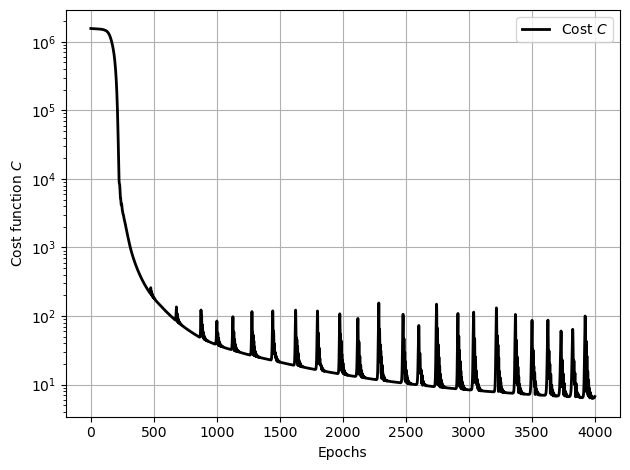

In [25]:
fig, ax = plt.subplots()
ax.set_xlabel("Epochs")
ax.set_ylabel("Cost function $C$")
ax.set_yscale("log")

ax.plot(costHistory, "k", linewidth=2, label="Cost $C$")

ax.grid()
ax.legend()
fig.tight_layout()
plt.show()

**displacement prediction**

/tmp/xpython_148290/16767099.py:3: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  uAnalytic = lambda x: (1.0 - np.cos(3.0 * np.pi * x))


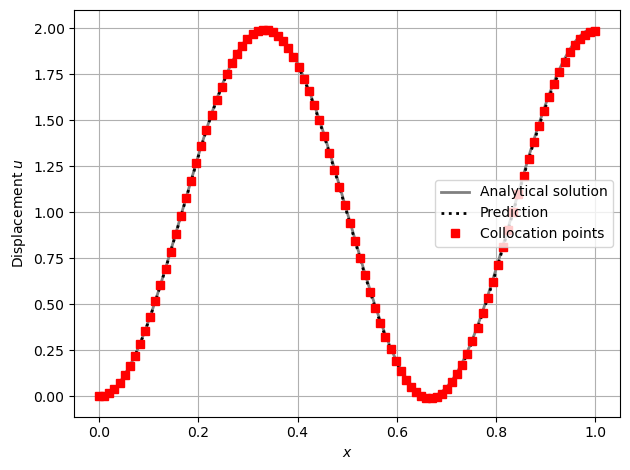

In [26]:
xTest = torch.linspace(0, L, 1000).unsqueeze(1)
uPredTest = getDisplacements(modelU, xTest, uB, L).detach()
uPred = getDisplacements(modelU, x, uB, L).detach()

fig, ax = plt.subplots()
ax.set_xlabel("$x$")
ax.set_ylabel("Displacement $u$")

ax.plot(xTest, uAnalytic(xTest), "gray", linewidth=2, label="Analytical solution")
ax.plot(xTest, uPredTest, "k:", linewidth=2, label="Prediction")
ax.plot(x.detach(), uPred, "rs", markersize=6, label="Collocation points")

ax.grid()
ax.legend()
fig.tight_layout()
plt.show()